# Convolution Neural Networks (CNN) - VGG16 (Fine tuned)

###  Deep learning on images

Classify images into two categories(Ankur vs Priyanka) using fine tuned VGG16 CNN model and Keras library.

#### VGG16

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. It was submitted to Large Scale Visual Recognition Challenge 2014 (ILSVRC2014) and The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another.

The VGG() class takes a few arguments that may only interest you if you are looking to use the model in your own project, e.g. for transfer learning.

For example:
 - **include_top** (True): Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
 - **weights** (‘imagenet‘): What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
 - **input_tensor** (None): A new input layer if you intend to fit the model on new data of a different size.
 - **input_shape** (None): The size of images that the model is expected to take if you change the input layer.
 - **pooling** (None): The type of pooling to use when you are training a new set of output layers.
 - **classes** (1000): The number of classes (e.g. size of output vector) for the model.
 
Next, let’s look at using the loaded VGG model to classify ad hoc photographs.

https://arxiv.org/abs/1409.1556v6

#### Data
You can prepare your own data of images or you can download the cat vs dog images from the kaggle website - 
https://www.kaggle.com/c/dogs-vs-cats/data

#### Reference:
https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Importing libraries and splitting the dataset

In [1]:
import numpy as np
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation, Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.utils.vis_utils import plot_model
from keras import backend as k
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rn
import os.path
from os import path

Using TensorFlow backend.


## Confirm if Tensorflow and Keras sees the GPU

In [2]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

W0716 17:53:38.893002 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0716 17:53:38.894265 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0716 17:53:38.895293 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0716 17:53:38.901005 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14861745096078573734
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12096994994815882647
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7336801005097848240
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9273456263237336889
physical_device_desc: "device: XLA_GPU device"
]
['/job:localhost/replica:0/task:0/device:GPU:0']


### Random Seed for Reproducible results
If you want your model to predict the same results on the same data then initialize the random seeds as explained below.

In [3]:
os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for numpy-generated random numbers
np.random.seed(37)
# Setting the seed for Python random numbers
rn.seed(1254)
# Setting the seed for Tensorflow random numbers
tf.set_random_seed(89)
# Force Tensorflow to use a single thread.
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

## Data Augmentation

In [4]:
# relative path to the train, test and validation data
train_path = 'data/train'
valid_path = 'data/valid'
test_path  = 'data/test'

In [5]:
# Data augmentation on training set

# rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
# rotation_range is a value in degrees (0–180), a range within which to ran- domly rotate pictures.
# zoom_range is for randomly zooming inside pictures.
# shear_range is for randomly applying shearing transformations.
# horizontal_flip is for randomly flipping half the images horizontally—rele-vant when there are no 
# assumptions of horizontal asymmetry (for example, real-world pictures).
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# validation data should not be augmented
valid_datagen = ImageDataGenerator(rescale=1./255)

# validation and test datagen should be same
test_datagen = ImageDataGenerator(rescale=1/.255)

In [6]:
train_batch_size = 32
valid_batch_size = 32
test_batch_size = 10

# The input training images can be of any size and target_size parameter will resize the input images to 224x224
train_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=train_batch_size)
valid_batches = valid_datagen.flow_from_directory(valid_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=valid_batch_size)
#test_batches  = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=60)
test_batches  = test_datagen.flow_from_directory(test_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=test_batch_size)

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


## Displaying some randomly augmented training images

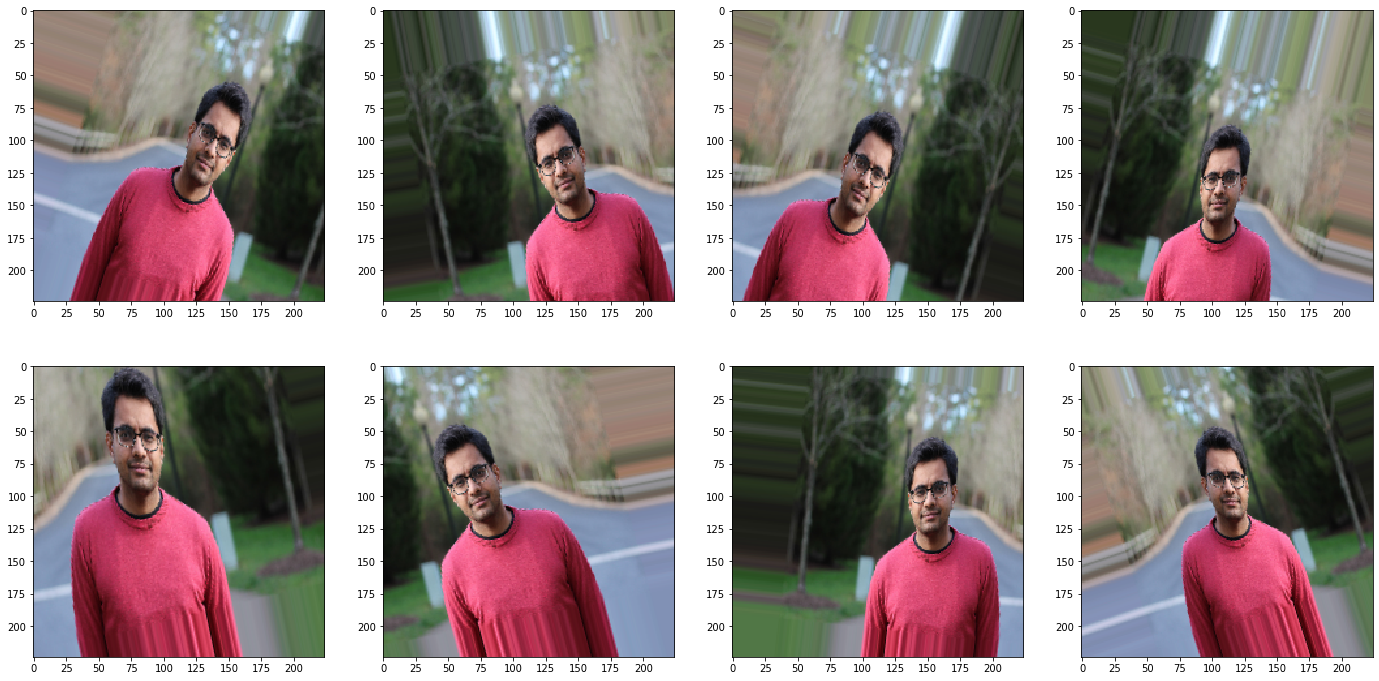

In [7]:
# Module with image-preporcessing utilities
from keras.preprocessing import image

train_dir_a = os.path.join(train_path, 'Ankur')
img_path = os.path.join(train_dir_a, 'IMG_3974.jpg')

# reads the image and resizes it
img = image.load_img(img_path, target_size=(224,224))

# converts it into numpy array with shape (224, 224, 3)
x = image.img_to_array(img)

# reshape image to (1, 224, 224, 3)
x = x.reshape((1,) + x.shape)

i=0

# Generates batches of randomly transformed images. Loops indefinitely, so we need to break the loop at some point!
f = plt.figure(figsize=(24,12))
for batch in train_datagen.flow(x, batch_size=1):
    sp = f.add_subplot(2, 4, i+1)
    # plt.figure(i, figsize=(24,12))
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i +=1 
    if i % 8 == 0:
        break
plt.show()

## Plot images with labels

In [8]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

/home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


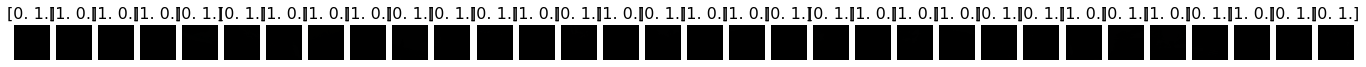

In [9]:
# Grab the batch of next images. In this case the batch_size is 10
imgs, labels = next(train_batches)
# Plot images from the training_set data
plots(imgs, titles=labels)

In [10]:
# Keras will download the VGG16 model to our system.
# include_top refers to including (or not) the densely connected classifier on top of the network.
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# VGG16 is not of type Sequential.
print("Type of model: %s" % type(vgg16_model))

# print the number of layers in the model
print("Number of layers: %d" % (len(vgg16_model.layers)))

# Summary of the VGG16 model. The output layer has 1000 nodes and is used to classify images into 1000
# different categories.
vgg16_model.summary()

# create a plot (only if does not already exist) of the layers in the VGG model, as follows:
if (not path.isfile('vgg16_without_top_layer.png')):
    plot_model(vgg16_model, to_file='vgg16_without_top_layer.png')

# Freeze the layers except the last 4 layers
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of individual layer
for layer in vgg16_model.layers:
    print(layer, layer.trainable)

W0716 17:53:43.213536 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 17:53:43.244239 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Type of model: <class 'keras.engine.training.Model'>
Number of layers: 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bl

In [11]:
# Create a new model
model_cnn = Sequential()

# Add the vgg convolution base model
model_cnn.add(vgg16_model)

# Add new fully connected layers
model_cnn.add(Flatten())
model_cnn.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model_cnn.add(keras.layers.Dropout(0.5))
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

In [12]:
# print the type of model
print(type(model_cnn))
# print the number of layers in the model
print('Number of layers=', len(model_cnn.layers))

<class 'keras.engine.sequential.Sequential'>
Number of layers= 6


In [13]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 127,970,114
Trainable params: 120,334,850
Non-trainable params: 7,635,264
______________________________________________________

In [14]:
model_cnn.compile(loss='binary_crossentropy', 
                  # optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                  # optimizer=optimizers.RMSprop(lr=1e-4), 
                  optimizer=optimizers.Adam(lr=1e-4), 
                  metrics = ['accuracy'])

W0716 17:53:44.796056 139767296288128 deprecation_wrapper.py:119] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0716 17:53:44.806773 139767296288128 deprecation.py:323] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Training the Fine tuned VGG16 model

In [15]:
print ('steps_per_epoch: %d' % (train_batches.samples/train_batches.batch_size))
print ('validation_steps:%d' % (valid_batches.samples/valid_batches.batch_size))

# By default, shuffle is True and it tells that the order of data your model is 
# iterating with each run/epoch will be different.
history = model_cnn.fit_generator(train_batches, 
                    steps_per_epoch=train_batches.samples/train_batches.batch_size,
                    validation_data=valid_batches, 
                    validation_steps=valid_batches.samples/valid_batches.batch_size, 
                    epochs=15, 
                    verbose=1,
                    workers=6)

steps_per_epoch: 15
validation_steps:3
Epoch 1/15
15/15 [==============================] - 37s 2s/step - loss: 90.4017 - acc: 0.5188 - val_loss: 80.8330 - val_acc: 0.5000
Epoch 2/15
15/15 [==============================] - 9s 571ms/step - loss: 73.2321 - acc: 0.5375 - val_loss: 65.0187 - val_acc: 0.6833
Epoch 3/15
15/15 [==============================] - 9s 577ms/step - loss: 58.7301 - acc: 0.7604 - val_loss: 52.1559 - val_acc: 0.7750
Epoch 4/15
15/15 [==============================] - 10s 652ms/step - loss: 47.1332 - acc: 0.8583 - val_loss: 42.0931 - val_acc: 0.8000
Epoch 5/15
15/15 [==============================] - 10s 683ms/step - loss: 38.0951 - acc: 0.8958 - val_loss: 34.4135 - val_acc: 0.7583
Epoch 6/15
15/15 [==============================] - 11s 706ms/step - loss: 31.0142 - acc: 0.9354 - val_loss: 27.8837 - val_acc: 0.9250
Epoch 7/15
15/15 [==============================] - 10s 689ms/step - loss: 25.5439 - acc: 0.9313 - val_loss: 23.1513 - val_acc: 0.9167
Epoch 8/15
15/15 [===

### Save Model

In [45]:
#Save the file only if it's not already present.
print(not path.isfile('VGG16_AP.h5'))

if(not path.isfile('VGG6_AP.h5')):
    model_cnn.save('VGG16_AP.h5')

True


In [46]:
# model_cnn.get_weights()

## Displaying curves of loss and accuracy during training

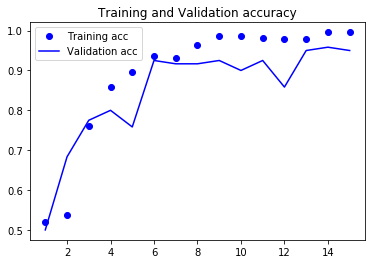

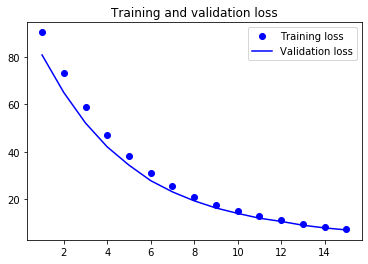

In [47]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot accuracy of Training and Validation set
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict using fined tune VGG16 model

In [38]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

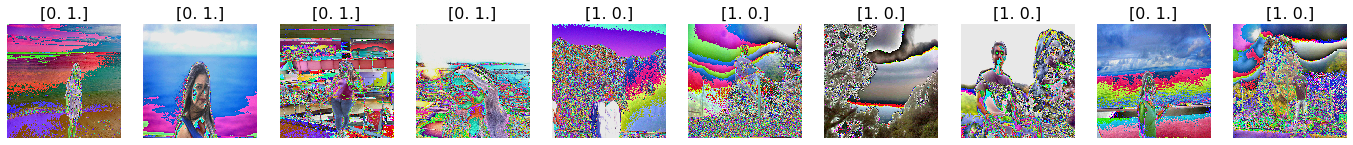

In [39]:
# Ankur's images are labeled as (1,0) and Priyanka's images are labeled as (0,1)
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [40]:
# Ankur's images will be labeled as 1 instead of (1,0) 
# and Priyanka's imges will be labeled as 0 instead of (0,1)
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)

In [44]:
#predictions = model_cnn.predict(train_batches, batch_size=10, verbose=0)

# If there are 72 test images in total and the batch_size is 10 then steps = 72/10 = 7.2
# Alternatively, if there are 60 test images and the batch_size is 60 then steps=1
predictions = model_cnn.predict_generator(test_batches, steps=10, verbose=0)
#print(predictions)

## Confusion Matrix
    

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment = 'center',
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [ ]:
cm_plots_labels = ['Ankur', 'Priyanka']
plot_confusion_matrix(cm, cm_plots_labels, title='Confusion Matrix')